In [1]:
import working_dir
working_dir.set_wd()

In [2]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

In [3]:
from src.dao import data_globals
from src.processing import entidade_urna
from src.utils import stats, dflib
from src.utils import pretties as prt

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
FILEPATH_PROC_IBGE_PIB = data_globals.FILEPATH_PROC_IBGE_PIB
FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T = data_globals.FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T

In [6]:
# COLS_PIV = [('13', 2009), ('22', 2009),
#             ('13', 2010), ('22', 2010),
#             ('13', 2011), ('22', 2011),
#             ('13', 2013), ('22', 2013),
#             ('13', 2015), ('22', 2015),
#             ('13', 2020), ('22', 2020),
#              'qtd_modelos']

# COLS_PIV_STR = ['13_2009', '22_2009', 
#                 '13_2010', '22_2010', 
#                 '13_2011', '22_2011', 
#                 '13_2013', '22_2013', 
#                 '13_2015', '22_2015', 
#                 '13_2020', '22_2020', 
#                 'qtd_modelos']

# def intersection(list_a, list_b):
#     #inplace
#     intersection_list = []
    
#     for el in list_a:
#         if el in list_b:
#             intersection_list.append(el)
    
#     return intersection_list

# def count_votacao_por_endereco_modelo_urna(df, cols_endereco):
#     return df.groupby(cols_endereco + ["modelo_urna"])[["13", "22"]].sum()

# def count_unique_modelos_por_endereco(df, cols_endereco):
#     return df.groupby(cols_endereco)["modelo_urna"].nunique().sort_values(ascending=False).to_frame("qtd_modelos")

# def pivot_votacao_por_endereco_modelo_urna(df, cols_endereco):
#     d = count_votacao_por_endereco_modelo_urna(df, cols_endereco).reset_index()
#     return d.pivot(index=cols_endereco,
#                    values=["13", "22"], 
#                    columns="modelo_urna")

# def tuple_columns_to_str_column(tuple_columns):
#     columns = [[col[0], str(col[1])] for col in tuple_columns]
#     return ["_".join(col) if col[1] != "" else col[0] for col in columns]
    

# def votacao_por_endereco_modelo_urna_com_contagem_modelos(df, cols_endereco):
#     votacao_pivot = pivot_votacao_por_endereco_modelo_urna(df, cols_endereco).reset_index()
#     votacao_pivot.columns = tuple_columns_to_str_column(votacao_pivot.columns.tolist())

#     modelos_count = count_unique_modelos_por_endereco(df, cols_endereco).reset_index()
#     votacao_pivot = votacao_pivot.merge(modelos_count, on=cols_endereco, how="left")
    
#     use_cols_piv = intersection(COLS_PIV_STR, votacao_pivot.columns)
    
#     return votacao_pivot[cols_endereco + use_cols_piv]

# Carregando dados

In [7]:
DFBU_COLS = ['SG_UF', 'CD_MUNICIPIO', 'NM_MUNICIPIO', 
             'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', "NM_LOCAL_VOTACAO",
             'NR_PARTIDO', 'QT_APTOS', 'QT_COMPARECIMENTO', 'QT_ABSTENCOES',
             'DS_TIPO_VOTAVEL', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS',
             'NR_URNA_EFETIVADA', "modelo_urna"]

DFBU_DTYPE = {'SG_UF': str, 'CD_MUNICIPIO': str, 'NM_MUNICIPIO': str, 
              'NR_ZONA': str, 'NR_SECAO': str, 'NR_LOCAL_VOTACAO': str,
              'NR_PARTIDO': str, 'QT_APTOS': int, 'QT_COMPARECIMENTO': int, 'QT_ABSTENCOES': int,
              'DS_TIPO_VOTAVEL': str, 'NR_VOTAVEL': str, 'NM_VOTAVEL': str, 'QT_VOTOS': int,
              'NR_URNA_EFETIVADA': str, "modelo_urna": str}

In [8]:
CORES_CANDIDATOS = {"13": "#de0100", "22": "#1f5f5b"}

MODELO_URNA_BINARIO = {"2020": "modelo 2020", "2009": "modelo anterior", 
                       "2010": "modelo anterior", "2011": "modelo anterior", 
                       "2013": "modelo anterior", "2015": "modelo anterior"}

COR_MODELO_URNA_BINARIO = {"modelo 2020": "#f3aa20", "modelo anterior": "#0162a7"}

In [9]:
ESTADO = "Brasil"

In [10]:
dfbu = pd.read_csv(FILEPATH_PROC_TSE_BOLETINS_DE_URNA_2T, sep=";", encoding='latin1', 
                   usecols=DFBU_COLS, dtype=DFBU_DTYPE)

dfbu["modelo_urna_binario"] = dfbu["modelo_urna"].replace(MODELO_URNA_BINARIO)

if ESTADO != "Brasil":
    dfbu = dfbu[dfbu["SG_UF"] == ESTADO]

print("dfbu.shape", dfbu.shape)

dfbu.shape (1850891, 18)


In [11]:
dfbu.sample(5)

,SG_UF,CD_MUNICIPIO,NR_ZONA,NR_SECAO,NR_LOCAL_VOTACAO,NR_PARTIDO,QT_APTOS,QT_COMPARECIMENTO,QT_ABSTENCOES,DS_TIPO_VOTAVEL,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_URNA_EFETIVADA,modelo_urna,NM_MUNICIPIO,NM_LOCAL_VOTACAO,modelo_urna_binario
1382548,SC,81396,64,171,1015,-1,382,308,74,Branco,95,Branco,5,1804636,2015,ILHOTA,ESCOLA DE EDUCAÃÃO BÃSICA MARCOS KONDER,modelo anterior
88155,BA,38490,18,470,1520,13,431,363,68,Nominal,13,LULA,218,2232008,2020,SALVADOR,ESCOLA ABÃLIO CÃSAR BORGES,modelo 2020
1281492,RS,89311,101,57,1120,22,193,163,30,Nominal,22,JAIR BOLSONARO,82,1146197,2009,TENENTE PORTELA,ESC. EST. GENERAL OSORIO,modelo anterior
1413786,SP,71072,4,336,1155,-1,395,343,52,Branco,95,Branco,6,2031719,2020,SAO PAULO,COLÃGIO NOSSA SENHORA DE LOURDES,modelo 2020
1252173,RS,89176,53,164,1619,-1,346,279,67,Branco,95,Branco,7,1299608,2010,SOBRADINHO,ESCOLA MUNICIPAL SEOMAR MAINARDI - RIO BRANCO,modelo anterior


# Tabela da entidade Urna Eletrônica
A variável dfu representa a votação a nível de Urna Eletrônica

In [12]:
index_urna = ["SG_UF", "NR_ZONA", "NR_SECAO", "CD_MUNICIPIO", "NR_LOCAL_VOTACAO", "NR_URNA_EFETIVADA", 
              "modelo_urna", "modelo_urna_binario", "NM_MUNICIPIO", "NM_LOCAL_VOTACAO"]

dfu = dfbu.pivot(columns="NR_VOTAVEL", values="QT_VOTOS", index=index_urna)
dfu = dfu.reset_index().rename(columns={"96": "Nulo", "95": "Branco"})
dfu.columns.name = None
dfu[["13", "22", "Branco", "Nulo"]] = dfu[["13", "22", "Branco", "Nulo"]].fillna(0).astype(int)

dfu.sample(5)

,SG_UF,NR_ZONA,NR_SECAO,CD_MUNICIPIO,NR_LOCAL_VOTACAO,NR_URNA_EFETIVADA,modelo_urna,modelo_urna_binario,NM_MUNICIPIO,NM_LOCAL_VOTACAO,13,22,Branco,Nulo
220781,PE,143,56,24490,1031,1285904,2010,modelo anterior,ITAIBA,ESCOLA PRESIDENTE EMÃLIO GARRASTAZU MÃDICI,181,30,3,14
239898,PI,45,84,10294,1449,1313416,2010,modelo anterior,BATALHA,UNIDADE ESCOLAR ANTONIO PEDRO DE ALMEIDA - ZÃ...,73,8,0,2
229835,PE,6,394,25313,1589,2171993,2020,modelo 2020,RECIFE,ESCOLA ROTARY DE NOVA DESCOBERTA,181,140,6,24
14039,AM,6,216,2534,1775,1269706,2010,modelo anterior,MANACAPURU,E. M. NOVA ESPERANÃA,73,24,1,8
48450,BA,76,155,35858,1066,1068388,2009,modelo anterior,IRAJUBA,CRECHE TIA MARA,247,44,2,14


In [13]:
dfu[["NR_ZONA", "NR_URNA_EFETIVADA"]].shape, dfu[["NR_ZONA", "NR_URNA_EFETIVADA"]].drop_duplicates().shape

((472027, 2), (471991, 2))

,Absoluto,Relativo
2020,192691,0.408220
2010,93795,0.198707
2015,85735,0.181632
2009,48245,0.102208
2011,26889,0.056965
2013,24672,0.052268


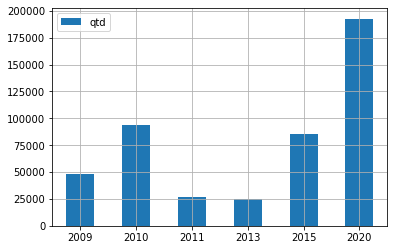

In [14]:
qtd_urnas = dfu["modelo_urna"].astype(str).value_counts().to_frame("qtd").sort_index()
prt.display(stats.freq(dfu["modelo_urna"].astype(str)))
qtd_urnas.plot.bar(rot=0, grid=True)
plt.show()

In [15]:
# SAO PAULO
# Jair Bolsonaro: 14.216.587 (55,24%) 
# Lula 11.519.882 (44,76%)

# PARAIBA
# Lula (PT): 66,62% dos votos válidos (1.601.953 votos)
# Jair Bolsonaro (PL): 33,38% dos votos válidos (802.502 votos)

# BRASIL
# Lula 60.345.999 votos (50,90% dos votos válidos)
# Jair Bolsonaro 58.206.354 votos (49,10% dos votos válidos).

votos_validos = dfu[["13", "22"]].sum().to_frame("votos")
votos_validos["%"] = votos_validos / votos_validos.sum()
prt.display(votos_validos)

,votos,%
13,60345999,0.509024
22,58206354,0.490976


In [16]:
urnas_unanimes = dfu[(((dfu["13"] == 0) & (dfu["22"] > 0)) | ((dfu["13"] > 0) & (dfu["22"] == 0)))]
len(urnas_unanimes)

147

In [17]:
ESTADO

'Brasil'

In [18]:
COLS_ENDERECO = ["SG_UF", "NM_MUNICIPIO", "NR_ZONA", "NR_LOCAL_VOTACAO"]

votos_modelo_endereco = entidade_urna.votacao_por_endereco_modelo_urna_com_contagem_modelos(dfu, COLS_ENDERECO)
votos_modelo_endereco[["13_2009", "13_2010", "13_2011", "13_2013", "13_2015", "13_2020"]].sum().sum()

60345999.0

# <font color='magenta'>Votação Por Modelo de Urna</font>

,13,22,13_percentual,22_percentual,Lula %,Bolsonaro %
modelo_urna,,,,,,
2011,3432852,2943287,0.538390,0.461610,0.538390,0.461610
2010,12070380,10379355,0.537662,0.462338,0.537662,0.462338
2015,10766404,10114104,0.515620,0.484380,0.515620,0.484380
2013,3001068,2857302,0.512270,0.487730,0.512270,0.487730
2009,5963745,5722585,0.510318,0.489682,0.510318,0.489682
2020,25111550,26189721,0.489492,0.510508,0.489492,0.510508


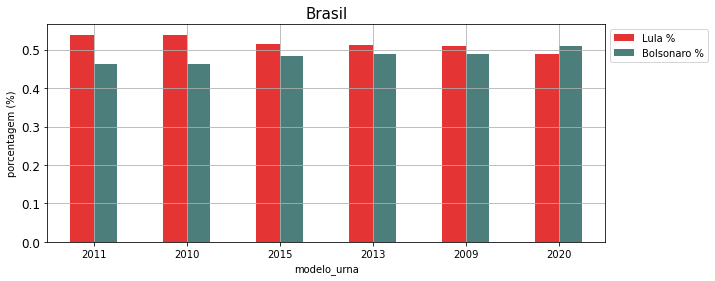

In [19]:
votos_por_modelo = dfu.groupby("modelo_urna")[["13", "22"]].sum()
votos_por_modelo["13_percentual"] = votos_por_modelo["13"] / votos_por_modelo.sum(axis=1)
votos_por_modelo["22_percentual"] = votos_por_modelo["22"] / votos_por_modelo.sum(axis=1)

votos_por_modelo = votos_por_modelo.sort_values("13_percentual", ascending=False)

votos_por_modelo["Lula %"] = votos_por_modelo["13_percentual"]
votos_por_modelo["Bolsonaro %"] = votos_por_modelo["22_percentual"]

prt.display(votos_por_modelo)

ax = votos_por_modelo[["Lula %", "Bolsonaro %"]].plot.bar(title=ESTADO, rot=0, grid=True, figsize=(10,4), 
                                                                   color=[CORES_CANDIDATOS["13"], 
                                                                          CORES_CANDIDATOS["22"]], alpha=0.8)

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set(ylabel='porcentagem (%)')
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=10)
ax.title.set_size(15)
plt.show()
plt.show()

# <font color='magenta'>Urna vs PIB</font>

In [20]:
pib = pd.read_csv(FILEPATH_PROC_IBGE_PIB, sep=";")[["LOCAL", "PIB", "PIB_PER_CAPITA", "ESTADO", "SIGLA", "CAPITAL"]]
pib.sample(5)

,LOCAL,PIB,PIB_PER_CAPITA,ESTADO,SIGLA,CAPITAL
86,BOCA DO ACRE,237462000,7241.46,AMAZONAS,AM,MANAUS
3017,SENADOR FIRMINO,60963000,8023.55,MINAS GERAIS,MG,BELO HORIZONTE
5271,PARANATINGA,642282000,31510.66,MATO GROSSO,MT,CUIABA
2079,MATA DE SAO JOAO,981823000,22044.61,BAHIA,BA,SALVADOR
4972,SANTA MARIA,5701470000,20847.16,RIO GRANDE DO SUL,RS,PORTO ALEGRE


In [21]:
dfu_br = dfu[dfu["SG_UF"] != "ZZ"]
print("dfu_br.shape", dfu_br.shape)

df_pib = dfu_br.merge(pib[["SIGLA", "LOCAL", "PIB", "PIB_PER_CAPITA"]],
                      left_on=["SG_UF", "NM_MUNICIPIO"],
                      right_on=["SIGLA", "LOCAL"],
                      how="left").drop(["SIGLA", "LOCAL"], axis=1)

df_pib = df_pib[["SG_UF", "NM_MUNICIPIO", "modelo_urna", "modelo_urna_binario", "PIB_PER_CAPITA", "NR_URNA_EFETIVADA"]].drop_duplicates()

print("df_pib.shape", df_pib.shape)

print()
print("ISNA")
cidades_sem_pib_encontrado = df_pib[(df_pib["PIB_PER_CAPITA"].isna())][["SG_UF", "NM_MUNICIPIO"]].drop_duplicates()
print(len(cidades_sem_pib_encontrado), "cidades sem pib encontrado")
print(f"Totalizando {len(df_pib[(df_pib['PIB_PER_CAPITA'].isna())][['SG_UF', 'NM_MUNICIPIO']])} urnas")
prt.display(cidades_sem_pib_encontrado)

print()
print()

prt.display(df_pib.sample(5))

dfu_br.shape (471010, 14)
df_pib.shape (471005, 6)

ISNA
4 cidades sem pib encontrado
Totalizando 88 urnas


,SG_UF,NM_MUNICIPIO
306889,RN,CAMPO GRANDE
309930,RN,BOA SAUDE
309932,RN,SERRA CAIADA
470568,TO,TABOCAO


,SG_UF,NM_MUNICIPIO,modelo_urna,modelo_urna_binario,PIB_PER_CAPITA,NR_URNA_EFETIVADA
393025,SP,ESTRELA D'OESTE,2010,modelo anterior,50569.15,1308384
395704,SP,SAO PAULO,2009,modelo anterior,48275.45,1170298
50813,BA,SALVADOR,2020,modelo 2020,18264.13,2243669
168134,MG,ENTRE FOLHAS,2009,modelo anterior,7095.55,1154522
202492,PA,SANTAREM,2011,modelo anterior,11552.78,1625620


,PIB_PER_CAPITA
modelo_urna,
2010,22146.237895
2011,22395.968892
2009,23114.426072
2013,23940.125197
2015,26188.642447
2020,29505.753215


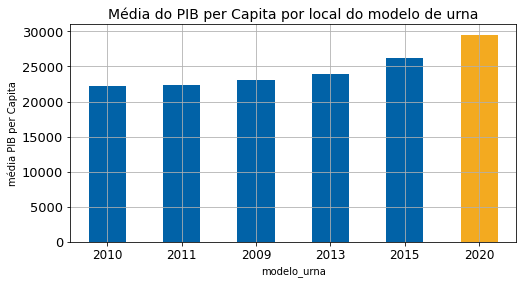

In [22]:
pibp_modelo = df_pib.groupby("modelo_urna")["PIB_PER_CAPITA"].mean().to_frame().sort_values("PIB_PER_CAPITA")
prt.display(pibp_modelo)

pibp_modelo["cor_modelo_urna"] = pibp_modelo.reset_index()["modelo_urna"].replace(entidade_urna.COLOR_MODELO_URNA).tolist()

fig, ax = plt.subplots()
ax = pibp_modelo["PIB_PER_CAPITA"].plot.bar(title="Média do PIB per Capita por local do modelo de urna", 
                                                 color=pibp_modelo["cor_modelo_urna"],
                                                 rot=0, grid=True, figsize=(8,4))

# We change the fontsize of minor ticks label 
ax.set(ylabel='média PIB per Capita')
ax.tick_params(axis='y', which='major', labelsize=13)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.title.set_size(14)
plt.show()